In [1]:
import scipy.io as sio

# Load files
normal_data = sio.loadmat("../data/raw/normal/118.mat")
fault_data = sio.loadmat("../data/raw/inner_race/105.mat")

# Inspect keys
print(normal_data.keys())
print(fault_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'X118_DE_time', 'X118_FE_time', 'X118_BA_time', 'X118RPM'])
dict_keys(['__header__', '__version__', '__globals__', 'X105_DE_time', 'X105_FE_time', 'X105_BA_time', 'X105RPM'])


In [2]:
normal_signal = normal_data['X118_DE_time'].flatten()
fault_signal = fault_data['X105_DE_time'].flatten()

print(normal_signal.shape)
print(fault_signal.shape)


(122571,)
(121265,)


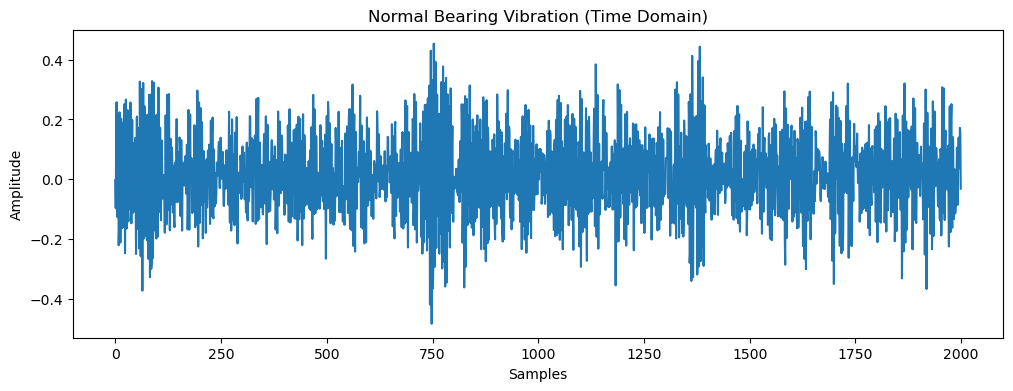

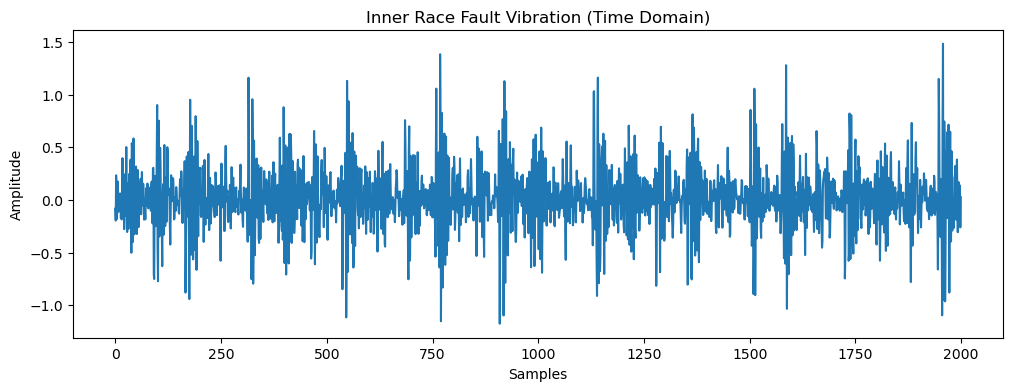

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(normal_signal[:2000])
plt.title("Normal Bearing Vibration (Time Domain)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(fault_signal[:2000])
plt.title("Inner Race Fault Vibration (Time Domain)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


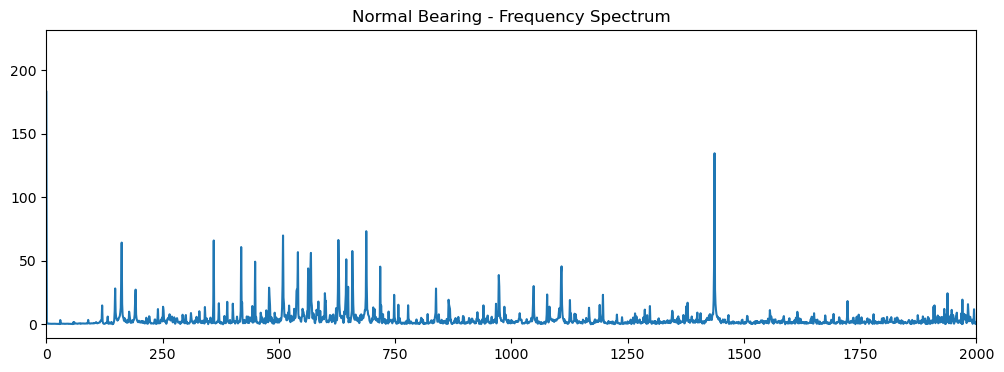

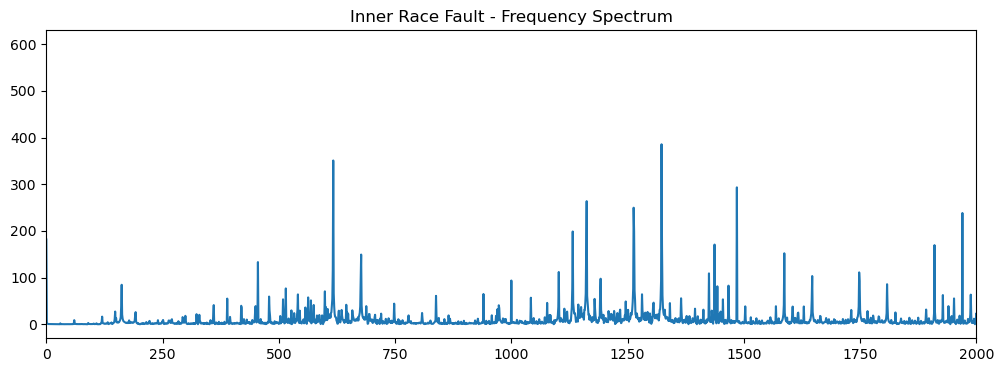

In [4]:
import numpy as np

fs = 12000  # Sampling frequency

def compute_fft(signal):
    fft_vals = np.abs(np.fft.rfft(signal))
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    return freqs, fft_vals

freq_n, fft_n = compute_fft(normal_signal[:12000])
freq_f, fft_f = compute_fft(fault_signal[:12000])

plt.figure(figsize=(12,4))
plt.plot(freq_n, fft_n)
plt.title("Normal Bearing - Frequency Spectrum")
plt.xlim(0, 2000)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(freq_f, fft_f)
plt.title("Inner Race Fault - Frequency Spectrum")
plt.xlim(0, 2000)
plt.show()


In [6]:
### Observations
#Normal signal shows smooth periodic behavior
#Inner race fault signal contains impulsive spikes
#FFT of faulty signal shows higher spectral energy

In [7]:
import numpy as np

def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

normal_norm = normalize(normal_signal)
fault_norm = normalize(fault_signal)


In [8]:
def segment_signal(signal, window_size=2048, overlap=0.5):
    step = int(window_size * (1 - overlap))
    segments = []
    for start in range(0, len(signal) - window_size, step):
        segments.append(signal[start:start + window_size])
    return np.array(segments)

normal_segments = segment_signal(normal_norm)
fault_segments = segment_signal(fault_norm)

print("Normal segments:", normal_segments.shape)
print("Fault segments:", fault_segments.shape)


Normal segments: (118, 2048)
Fault segments: (117, 2048)


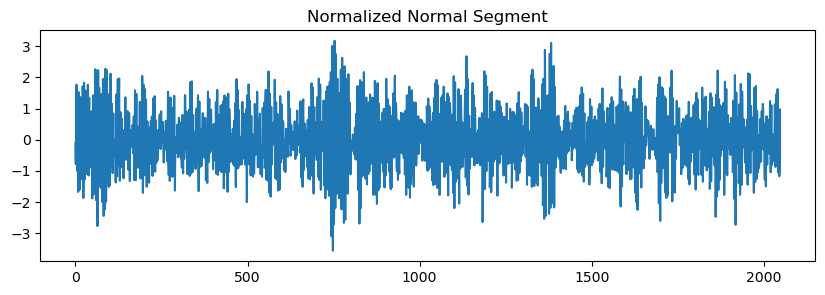

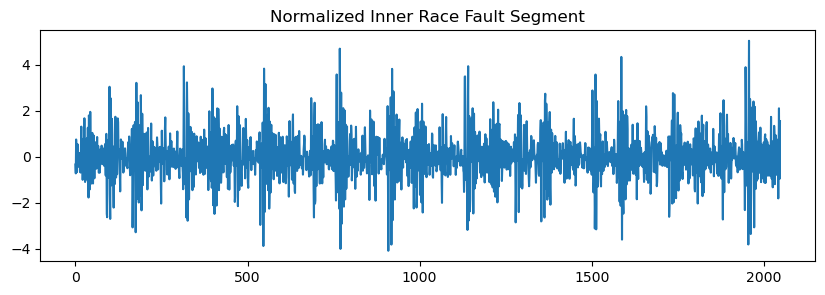

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(normal_segments[0])
plt.title("Normalized Normal Segment")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(fault_segments[0])
plt.title("Normalized Inner Race Fault Segment")
plt.show()


In [10]:
X = np.vstack((normal_segments, fault_segments))

y = np.array(
    [0]*len(normal_segments) +  # Normal
    [1]*len(fault_segments)     # Inner race fault
)

In [11]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)


In [17]:
import os

base_path = "../data/processed/segmented"
os.makedirs(base_path, exist_ok=True)


In [18]:
np.save(os.path.join(base_path, "X_segments.npy"), X)
np.save(os.path.join(base_path, "y_labels.npy"), y)


In [19]:
os.listdir(base_path)


['X_segments.npy', 'y_labels.npy']

In [20]:
import numpy as np

X = np.load("../data/processed/segmented/X_segments.npy")
y = np.load("../data/processed/segmented/y_labels.npy")

print(X.shape, y.shape)

(235, 2048) (235,)


In [21]:
from scipy.stats import skew, kurtosis

def time_features(segment):
    return [
        np.mean(segment),
        np.std(segment),
        np.sqrt(np.mean(segment**2)),   # RMS
        skew(segment),
        kurtosis(segment),
        np.ptp(segment)
    ]

In [22]:
def freq_features(segment, fs=12000):
    fft_vals = np.abs(np.fft.rfft(segment))
    freqs = np.fft.rfftfreq(len(segment), 1/fs)

    spectral_energy = np.sum(fft_vals**2)
    dominant_freq = freqs[np.argmax(fft_vals)]
    spectral_centroid = np.sum(freqs * fft_vals) / np.sum(fft_vals)

    return [spectral_energy, dominant_freq, spectral_centroid]


In [23]:
features = []

for segment in X:
    features.append(time_features(segment) + freq_features(segment))

X_features = np.array(features)

print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (235, 9)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

In [27]:
import os

base_path = "../data/processed/features"
os.makedirs(base_path, exist_ok=True)

In [28]:
np.save("../data/processed/features/X_features.npy", X_scaled)
np.save("../data/processed/features/y_features.npy", y)

In [29]:
import pandas as pd

df = pd.DataFrame(X_scaled, columns=[
    "mean","std","rms","skew","kurtosis","ptp",
    "spectral_energy","dominant_freq","spectral_centroid"
])
df['label'] = y

df.groupby('label').mean()

,mean,std,rms,skew,kurtosis,ptp,spectral_energy,dominant_freq,spectral_centroid
label,,,,,,,,,
0,0.007920,-0.014723,-0.013611,-0.932003,-0.979795,-0.907927,-0.00239,-0.741754,0.433249
1,-0.007988,0.014848,0.013727,0.939969,0.988169,0.915687,0.00241,0.748094,-0.436952
